In [41]:
####################

## Working Notebook to add confeernce affilation to game data table

# Dependencies

import pandas as pd
import re
import numpy as np
import ast
import matplotlib.pyplot as plt
# import sns
import seaborn as sns

# Load Data
conference_df = pd.read_csv('../../data/yearly_conference_members.csv')
games_df = pd.read_csv('../../data/cfb_scrape_raw.csv')

# rename Unnamed: 0 to year in conference_df
conference_df = conference_df.rename(columns={'Unnamed: 0': 'Year'})



# Convert string representations of lists back into actual lists
for col in conference_df.columns[1:]:
    conference_df[col] = conference_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


C:\Users\Justin\AppData\Local\Temp\ipykernel_18212\3574501754.py:17: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv('../../data/cfb_scrape_raw.csv')


In [42]:
### Extract the ranking from the team name where applicable
## Pool ranking is contained in parentheses at the beginning of the team name string of the Winner and Loser columns
def extract_ranking(team_name):
    """Extract the ranking from the team name where applicable."""
    # If the team name does not start with a parenthesis, there is no ranking
    if team_name[0] != '(':
        return None
    
    # Find the closing parenthesis
    closing_paren = team_name.find(')')
    
    # Extract the ranking
    ranking = team_name[1:closing_paren]
    
    return ranking

# Apply function to Winner column and save in new 'Winner_Rank' column
games_df['Winner_Rank'] = games_df['Winner'].apply(extract_ranking)
# Apply function to Loser column and save in new 'Loser_Rank' column
games_df['Loser_Rank'] = games_df['Loser'].apply(extract_ranking)

# Remove the ranking from the team name
games_df['Winner'] = games_df['Winner'].str.replace(r"\(.*\)","")
games_df['Loser'] = games_df['Loser'].str.replace(r"\(.*\)","")

# Strip leading and trailing whitespace from team names
games_df['Winner'] = games_df['Winner'].str.strip()
games_df['Loser'] = games_df['Loser'].str.strip()

C:\Users\Justin\AppData\Local\Temp\ipykernel_18212\3795599030.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  games_df['Winner'] = games_df['Winner'].str.replace(r"\(.*\)","")
C:\Users\Justin\AppData\Local\Temp\ipykernel_18212\3795599030.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  games_df['Loser'] = games_df['Loser'].str.replace(r"\(.*\)","")


In [43]:
## Add conference affiliation to teams
import ast # for literal_eval function

conference_df = pd.read_csv('../../data/yearly_conference_members.csv')

# rename Unnamed: 0 to year in conference_df
conference_df = conference_df.rename(columns={'Unnamed: 0': 'Year'})

# Convert string representations of lists back into actual lists
for col in conference_df.columns[1:]:
    conference_df[col] = conference_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# Function to retrieve the conference based on year and team name
def get_conference(year, team_name, conference_lookup):
    """
    Given a year and team name, retrieve the conference the team belongs to.
    If no conference found, return "Independent/Unknown".
    """
    return conference_lookup.get((year, team_name), "Independent/Unknown")

# Create a lookup dictionary for team-year to conference mapping
conference_lookup = {}

for _, row in conference_df.iterrows():
    year = row['Year']
    for col, teams in row[1:].items():
        for team in teams:
            conference_lookup[(year, team)] = col

# Use funtion to assign conference affiliation the teams in each row but only if 
# the team name is not null
games_df['winner_conference'] = games_df.apply(lambda row: get_conference(row['Season'], row['Winner'], conference_lookup) if pd.notna(row['Winner']) else None, axis=1)
games_df['loser_conference'] = games_df.apply(lambda row: get_conference(row['Season'], row['Loser'], conference_lookup) if pd.notna(row['Loser']) else None, axis=1)


### Create a new column for conference and non-conference games
# Function to determine if a game is a conference game
def determine_conference_game(conference1, conference2):
    if conference1 == conference2:
        return 'Conference'
    else:
        return 'Non-Conference'
    
# Apply to create new 'game_type' column using the determine_conference_game function and the winner and loser conference columns
games_df['game_type'] = games_df.apply(lambda row: determine_conference_game(row['winner_conference'], row['loser_conference']) if pd.notna(row['winner_conference']) and pd.notna(row['loser_conference']) else None, axis=1)

# Set game type to Non-Conferecne if either team is Independent/Unknown
games_df.loc[games_df['winner_conference'] == 'Independent/Unknown', 'game_type'] = 'Non-Conference'
games_df.loc[games_df['loser_conference'] == 'Independent/Unknown', 'game_type'] = 'Non-Conference'

In [44]:
# Rename the points columns to be more to match code down the line
# Pts = winner_pts, Pts.1 = loser_pts
games_df = games_df.rename(columns={'Pts': 'winner_pts', 'Pts.1': 'loser_pts'})

# season_year to season
games_df = games_df.rename(columns={'Season': 'season'})

# unnamed: 6 to loc_ind
games_df = games_df.rename(columns={'Unnamed: 6': 'loc_ind'})

# make all column names lowercase
games_df.columns = games_df.columns.str.lower()

In [45]:
games_df.sample(20)
games_df.columns

Index(['rk', 'wk', 'date', 'day', 'winner', 'winner_pts', 'loc_ind', 'loser',
       'loser_pts', 'notes', 'season', 'time', 'unnamed: 7', 'winner_rank',
       'loser_rank', 'winner_conference', 'loser_conference', 'game_type'],
      dtype='object')

In [46]:
# WRITE TO CSV
games_df.to_csv('../../data/cfb_scrape_transformed.csv', index=False)

In [47]:
# games_df.info()

# value counts for winner and loser conference
# games_df['winner_conference'].value_counts()
# games_df['loser_conference'].value_counts()

# OUTPUT CSV TO TEMP FOLDER
# games_df.to_csv('../TEMP/ADJUSTED_cfb_scores_all_years.csv', index=False)

# Load The FBS Teams Table
fbs_teams_df = pd.read_csv('..\..\data\cfb_d1_teams_with_coordinates.csv')

In [48]:
games_df.head()
games_df.columns

Index(['rk', 'wk', 'date', 'day', 'winner', 'winner_pts', 'loc_ind', 'loser',
       'loser_pts', 'notes', 'season', 'time', 'unnamed: 7', 'winner_rank',
       'loser_rank', 'winner_conference', 'loser_conference', 'game_type'],
      dtype='object')

In [49]:
adjusted_games_df = games_df

# Extract the list of top division teams
d1_teams_list = fbs_teams_df['Team'].tolist()

# Filter the historical game data to only include games involving these teams
filtered_games_df = adjusted_games_df[(adjusted_games_df['winner'].isin(d1_teams_list)) | (adjusted_games_df['loser'].isin(d1_teams_list))]

# Display basic information and a sample of rows from the filtered dataframe
filtered_games_info = filtered_games_df.info()
filtered_games_sample = filtered_games_df.sample(30)

# filtered_games_info, filtered_games_sample


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65488 entries, 0 to 81605
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rk                 65488 non-null  int64  
 1   wk                 65488 non-null  int64  
 2   date               65488 non-null  object 
 3   day                65488 non-null  object 
 4   winner             65488 non-null  object 
 5   winner_pts         65487 non-null  float64
 6   loc_ind            24069 non-null  object 
 7   loser              65488 non-null  object 
 8   loser_pts          65487 non-null  float64
 9   notes              4949 non-null   object 
 10  season             65488 non-null  int64  
 11  time               7055 non-null   object 
 12  unnamed: 7         3432 non-null   object 
 13  winner_rank        14314 non-null  object 
 14  loser_rank         5738 non-null   object 
 15  winner_conference  65488 non-null  object 
 16  loser_conference   654

In [50]:

# Function to retrieve the conference based on year and team name
def get_conference(year, team_name, conference_lookup):
    """
    Given a year and team name, retrieve the conference the team belongs to.
    If no conference found, return "Independent/Unknown".
    """
    return conference_lookup.get((year, team_name), "Independent/Unknown")

# Create a lookup dictionary for team-year to conference mapping
conference_lookup = {}

for _, row in conference_df.iterrows():
    year = row['Year']
    for col, teams in row[1:].items():
        for team in teams:
            conference_lookup[(year, team)] = col

# Use funtion to assign conference affiliation the teams in each row but only if 
# the team name is not null
games_df['winner_conference'] = games_df.apply(lambda row: get_conference(row['season'], row['winner'], conference_lookup) if pd.notna(row['winner']) else None, axis=1)
games_df['loser_conference'] = games_df.apply(lambda row: get_conference(row['season'], row['loser'], conference_lookup) if pd.notna(row['loser']) else None, axis=1)


# Classify games as Regular Season or Post Season based on Date
games_df['date'] = pd.to_datetime(games_df['date'], errors='coerce')  # Convert the Date column to datetime format
games_df['season_type'] = games_df.apply(lambda row: "Post Season" if (row['date'].month == 12 and row['date'].day > 15) or row['date'].month == 1 else "Regular Season", axis=1)



### Create a new column for conference and non-conference games
# Function to determine if a game is a conference game
def determine_conference_game(conference1, conference2):
    if conference1 == conference2:
        return 'Conference'
    else:
        return 'Non-Conference'
    
# Apply to create new 'game_type' column using the determine_conference_game function and the winner and loser conference columns
games_df['game_type'] = games_df.apply(lambda row: determine_conference_game(row['winner_conference'], row['loser_conference']) 
                                       if pd.notna(row['winner_conference']) and pd.notna(row['loser_conference']) else None, axis=1)

# Set game type to Non-Conferecne if either team is Independent/Unknown
games_df.loc[games_df['winner_conference'] == 'Independent/Unknown', 'game_type'] = 'Non-Conference'
games_df.loc[games_df['loser_conference'] == 'Independent/Unknown', 'game_type'] = 'Non-Conference'


# Display the updated dataframe with the new columns
# games_df_new.sample(30)



In [51]:
# games_df.sample(20)

In [52]:
## Show breakdown of games by season type and game type
games_df.groupby(['season_type', 'game_type']).size()


season_type     game_type     
Post Season     Conference           41
                Non-Conference     1607
Regular Season  Conference        20028
                Non-Conference    59930
dtype: int64

In [53]:
# Rename to match
games_df_new = games_df
## Extract Notes for Bowl Game and Champ Game Names

# Value COunts
games_df_new['notes'].value_counts().head(20)

# If notes contains Bowl, then copy the notes to the bowl_game column
games_df_new['bowl_game'] = games_df_new.apply(lambda row: row['notes'] if isinstance(row['notes'], str) and 'Bowl' in row['notes'] else None, axis=1)
# Clear the Bowl Cells from the Notes Column
games_df_new['notes'] = games_df_new.apply(lambda row: None if isinstance(row['notes'], str) and 'Bowl' in row['notes'] else row['notes'], axis=1)




# value counts for bowl_game
games_df_new['bowl_game'].value_counts()
# Notes value count
# games_df_new['notes'].value_counts()

# Save new Csv to data folder as game_info_v2
# games_df_new.to_csv('../data/game_info_v2.csv', index=False)


Rose Bowl (Pasadena, CA)                                          102
Sugar Bowl (New Orleans, LA)                                       81
Sun Bowl (El Paso, TX)                                             81
Orange Bowl (Miami, FL)                                            79
Cotton Bowl (Dallas, TX)                                           73
                                                                 ... 
Poinsettia Bowl (Qualcomm Stadium - San Diego, California)          1
Miami Beach Bowl (Marlins Park - Miami, Florida)                    1
New Mexico Bowl (University Stadium - Albuquerque, New Mexico)      1
Cotton Bowl Stadium - Dallas Texas                                  1
Cotton Bowl                                                         1
Name: bowl_game, Length: 252, dtype: int64

In [54]:
# ## Transform to parse notes column for game sites, names, ect

#     # Identify Neutral Site Games
#     def is_neutral_site(row):
#         # All postseason games are at neutral sites
#         if row['season_type'] == 'Post Season':
#             return True
#         # Handle special event names in the 'Notes' column
#         keywords = ["Championship", "Classic", "Festival", "Cup", "Bowl"]
#         if pd.notnull(row['notes']) and any(keyword in row['notes'] for keyword in keywords):
#             return True
#         return False

#     df['IsNeutralSite'] = df.apply(is_neutral_site, axis=1)
    
#     # Handle games mentioning a specific location or stadium
#     stadium_note_games = df[df['Notes'].str.contains("Stadium|Field|Park|Arena|Dome", na=False)]
#     common_stadiums = stadium_note_games.groupby(['Notes']).size().reset_index(name='counts')
#     non_neutral_stadiums = common_stadiums[common_stadiums['counts'] > 2]['Notes'].tolist()
#     df.loc[df['Notes'].isin(non_neutral_stadiums), 'IsNeutralSite'] = False
    
#     # Save special event names in the bowl_game column if it's empty
#     def update_bowl_game(row):
#         if pd.isnull(row['bowl_game']):
#             keywords = ["Championship", "Classic", "Festival", "Cup", "Bowl"]
#             if pd.notnull(row['notes']) and any(keyword in row['notes'] for keyword in keywords):
#                 return row['notes']
#         return row['bowl_game']

#     df['bowl_game'] = df.apply(update_bowl_game, axis=1)
    
#     return df

# # Load the game_info_v2 CSV file and apply the transformation

# transformed_game_info_new = transform_game_info(games_df_new)

# # Display the first few rows of the transformed data
# transformed_game_info_new_head = transformed_game_info_new.head()
# transformed_game_info_new_head



In [55]:
# transformed_game_info_new_head.columns

In [56]:
# # Rename columns for clairity
# cols = ['season_index','week','date','day','winner','winner_pt','loc_ind',
#         'loser','loser_pt','location','season_year','time','loc_ind2',
#         'winner_ranking','loser_ranking','winner_conf','loser_conf',
#         'season_type', 'game_type', 'bowl_game', 'IsNeutralSite']

# transformed_game_info_new.columns = cols

In [57]:
# ## value counts for bowl_game
# transformed_game_info_new['bowl_game'].value_counts()

# # notes value count
# transformed_game_info_new['Notes'].value_counts()

# rename transformed_game_info to games_df_new
# games_df_new = transformed_game_info_new

# Save new Csv to data folder as game_info_v3
games_df_new.to_csv('../../data/cfb_game_data_expanded.csv', index=False)

In [58]:
# Add a coulmn with the Margin of Victory
# games_df_new['margin'] = games_df_new['Winner_Pts'] - games_df_new['Loser_Pts']

# value count of winner and loser ranking
games_df_new['winner_rank'].value_counts()

# games_df_new.columns

1     849
2     806
3     775
4     773
5     750
7     728
6     719
8     718
9     701
10    680
12    634
14    631
11    622
16    604
13    603
19    591
17    588
15    586
18    567
20    562
21    285
24    281
25    279
22    273
23    269
Name: winner_rank, dtype: int64

In [59]:
# save csv to data folder as game_info_v2
games_df_new.to_csv('../../data/cfb_game_data_expanded.csv', index=False)

In [63]:
games_df_new.columns

Index(['rk', 'wk', 'date', 'day', 'winner', 'winner_pts', 'loc_ind', 'loser',
       'loser_pts', 'notes', 'season', 'time', 'unnamed: 7', 'winner_rank',
       'loser_rank', 'winner_conference', 'loser_conference', 'game_type',
       'season_type', 'bowl_game'],
      dtype='object')

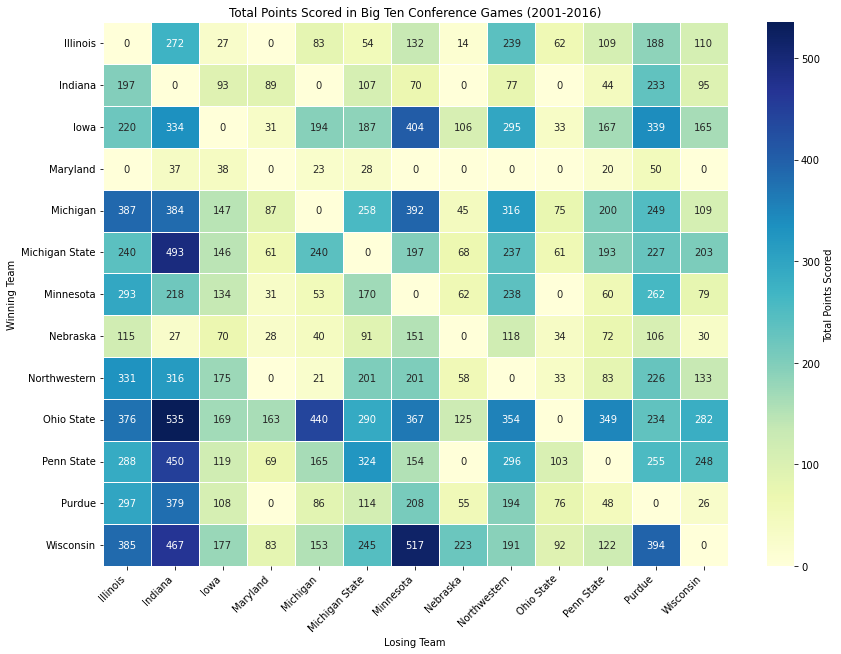

In [65]:
#####################################################################
# TESTING HEATMAP PLOTS WITH BIG TEN game_data
#####################################################################


game_data = games_df_new

# Filter data to only include games from 2011-2016, within the Big Ten Conference, and that are conference games
big_ten_data = game_data[(game_data['season'].between(2001, 2016)) & 
                         (game_data['winner_conference'] == 'Big Ten Conference') &
                          (game_data['loser_conference'] == 'Big Ten Conference') & 
                         (game_data['game_type'] == 'Conference')]

# Group by winner and loser to get sum of points scored
points_scored_big_ten = big_ten_data.groupby(['winner', 'loser']).agg({'winner_pts': 'sum'}).reset_index()

def plot_big_ten_heatmap(data):
    # Pivot the data for the heatmap
    heatmap_data = data.pivot('winner', 'loser', 'winner_pts')
    # Fill NaN with 0 and remove rows and columns that have only zeros
    heatmap_data = heatmap_data.fillna(0)
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1) > 0, heatmap_data.sum(axis=0) > 0]
    
    if heatmap_data.empty:
        print("No sufficient data available for the heatmap.")
        return
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f", cbar_kws={'label': 'Total Points Scored'})
    plt.title('Total Points Scored in Big Ten Conference Games (2001-2016)')
    plt.ylabel('Winning Team')
    plt.xlabel('Losing Team')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# Plot the heatmap for Big Ten Conference games from 2011-2016
plot_big_ten_heatmap(points_scored_big_ten)


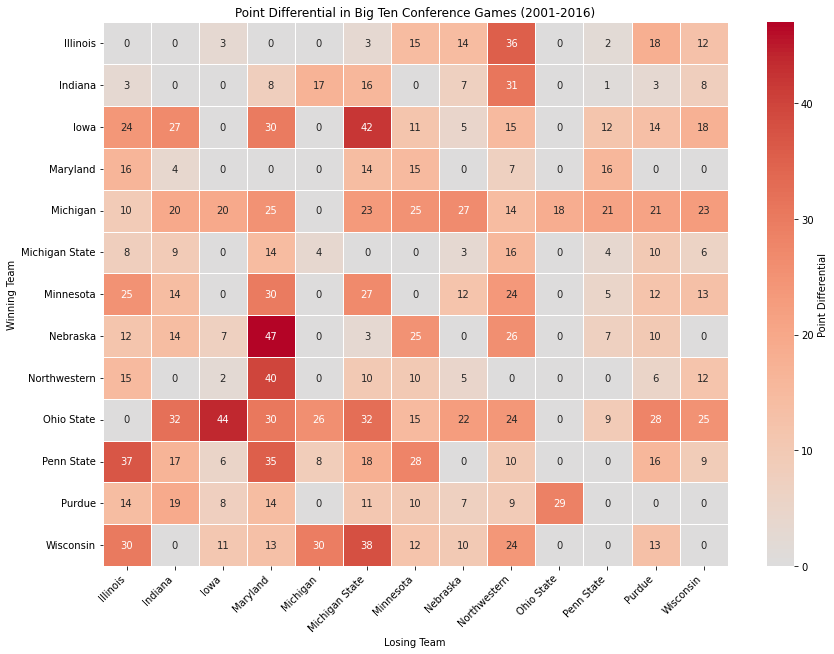

In [66]:

# Filter data to only include games from 2011-2016, within the Big Ten Conference, and that are conference games
big_ten_data = game_data[(game_data['season'].between(2018, 2023)) & 
                         (game_data['winner_conference'] == 'Big Ten Conference') &
                          (game_data['loser_conference'] == 'Big Ten Conference') & 
                         (game_data['game_type'] == 'Conference')]

big_ten_data_diff = big_ten_data.copy()
# Compute point differential for each game
big_ten_data_diff['point_diff'] = big_ten_data_diff['winner_pts'] - big_ten_data_diff['loser_pts']

# Group by winner and loser to get sum of point differentials
point_diff_big_ten = big_ten_data_diff.groupby(['winner', 'loser']).agg({'point_diff': 'mean'}).reset_index()

def plot_big_ten_diff_heatmap(data):
    # Pivot the data for the heatmap
    heatmap_data = data.pivot('winner', 'loser', 'point_diff')
    # Fill NaN with 0 and remove rows and columns that have only zeros
    heatmap_data = heatmap_data.fillna(0)
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1) > 0, heatmap_data.sum(axis=0) > 0]
    
    if heatmap_data.empty:
        print("No sufficient data available for the heatmap.")
        return
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, cmap="coolwarm", center=0, linewidths=.5, annot=True, fmt=".0f", cbar_kws={'label': 'Point Differential'})
    plt.title('Point Differential in Big Ten Conference Games (2001-2016)')
    plt.ylabel('Winning Team')
    plt.xlabel('Losing Team')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# Plot the heatmap for Big Ten Conference games from 2001-2016
plot_big_ten_diff_heatmap(point_diff_big_ten)


C:\Users\Justin\AppData\Local\Temp\ipykernel_18212\1126142343.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_updated['point_diff'] = filtered_data_updated['winner_pts'] - filtered_data_updated['loser_pts']
C:\Users\Justin\AppData\Local\Temp\ipykernel_18212\1126142343.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  pivot_data_active_conferences = pivot_data_updated.loc[active_conferences, active_conferences]


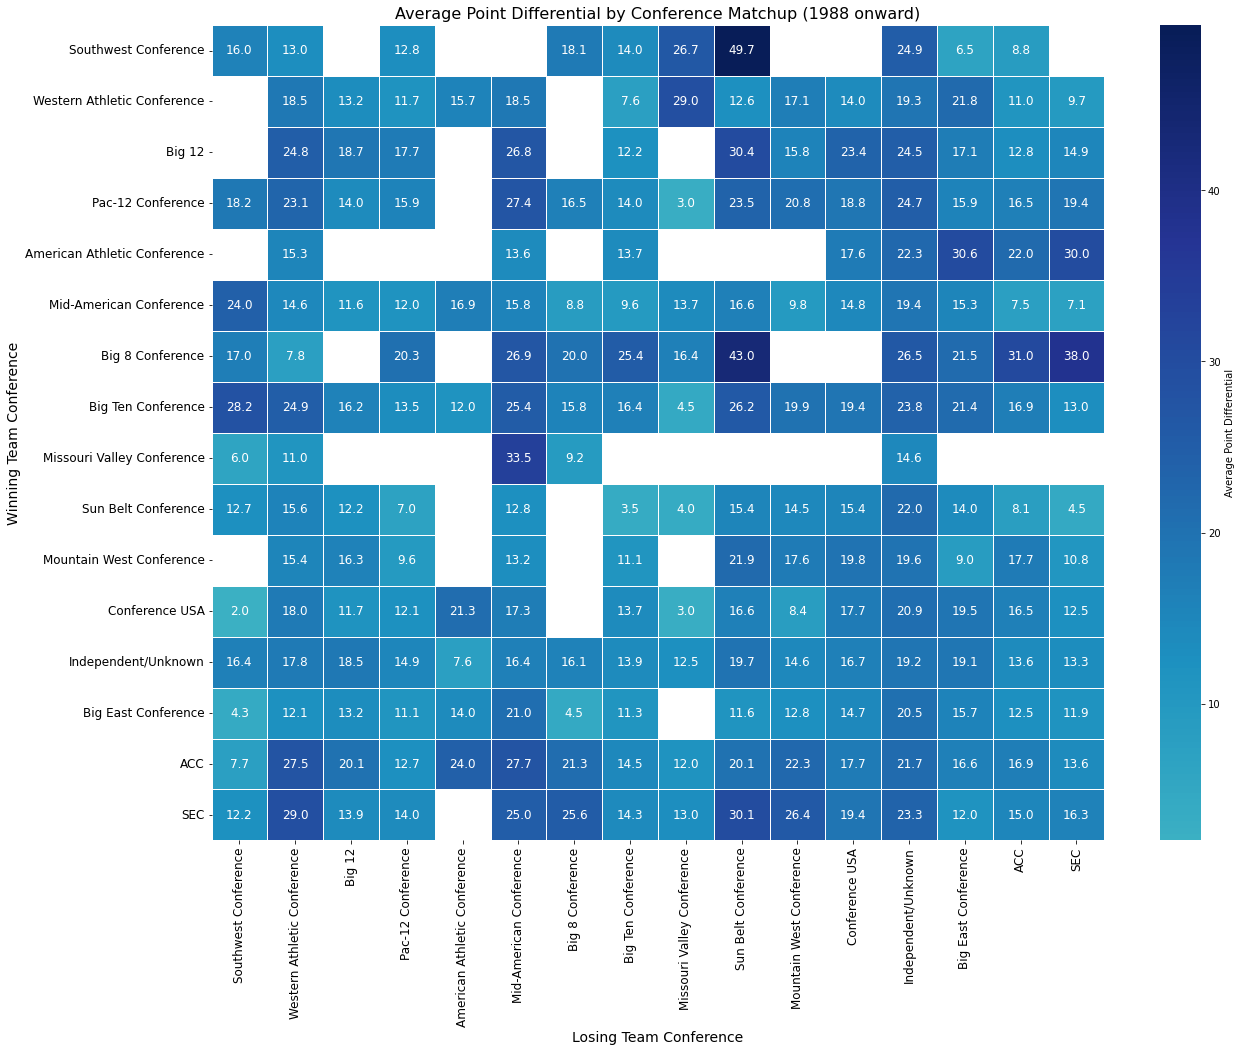

In [68]:
### Conference comparison Heatmap


# Load the provided CSV file
cfb_game_data_updated = game_data

# Filter the data to only include games from the 1988 season year onward
filtered_data_updated = cfb_game_data_updated[cfb_game_data_updated['season'] >= 1988]

# Calculate point differential for each game in the updated dataset
filtered_data_updated['point_diff'] = filtered_data_updated['winner_pts'] - filtered_data_updated['loser_pts']


# Determine all unique conferences active during this time
active_conferences = set(filtered_data_updated['winner_conference']).union(set(filtered_data_updated['loser_conference']))

# Create a pivot table to compute average point differential by conference matchups
pivot_data_updated = filtered_data_updated.pivot_table(index='winner_conference', columns='loser_conference', values='point_diff', aggfunc='mean')

# Filter the pivot table to only include active conferences
pivot_data_active_conferences = pivot_data_updated.loc[active_conferences, active_conferences]

# Plot heatmap with improved aesthetics
plt.figure(figsize=(20, 15))
sns.heatmap(pivot_data_active_conferences, annot=True, cmap='YlGnBu', center=0, linewidths=0.5, 
            cbar_kws={'label': 'Average Point Differential'}, annot_kws={"size": 12}, fmt=".1f")
plt.title("Average Point Differential by Conference Matchup (1988 onward)", fontsize=16)
plt.xlabel("Losing Team Conference", fontsize=14)
plt.ylabel("Winning Team Conference", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



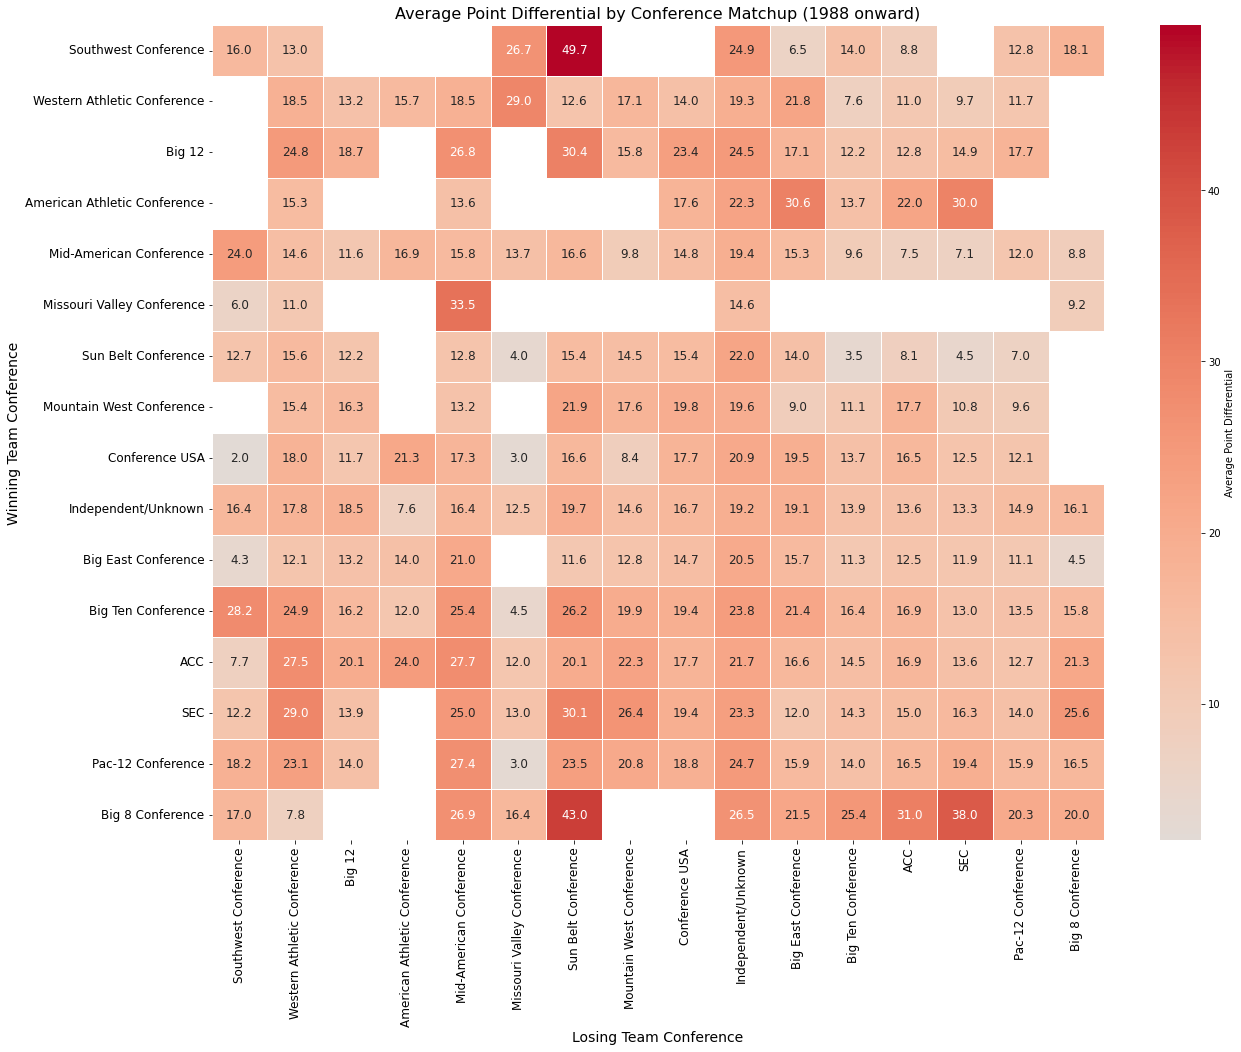

In [69]:
# Power Five Conferences
power_5_adjusted = ['Big Ten Conference', 'ACC', 'SEC', 'Pac-12 Conference', 'Big 8 Conference']

# Reorder the conferences with Power 5 at the end
reordered_conferences = [conf for conf in active_conferences if conf not in power_5_adjusted] + power_5_adjusted

# Filter the pivot table to only include active conferences and reorder them
pivot_data_reordered = pivot_data_updated.loc[reordered_conferences, reordered_conferences]

# Plot heatmap with the 'coolwarm' color scheme and reordered conferences
plt.figure(figsize=(20, 15))
sns.heatmap(pivot_data_reordered, annot=True, cmap='coolwarm', center=0, linewidths=0.5, 
            cbar_kws={'label': 'Average Point Differential'}, annot_kws={"size": 12}, fmt=".1f")
plt.title("Average Point Differential by Conference Matchup (1988 onward)", fontsize=16)
plt.xlabel("Losing Team Conference", fontsize=14)
plt.ylabel("Winning Team Conference", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
